<h1> Capstone 3: Data Wrangling and EDA </h1><a id='Capstone_3_Data_Wrangling_and_EDA'></a>

## Table of Contents<a id='Table_of_Contents'></a>
* [1 The Data Science Problem](#The_Data_Science_Problem)
    * [1.1 Context](#Context)
    * [1.2 Data Source Citation](#Data_Source_Citation)
    
* [2 Imports](#Imports)
    * [1.1 Import Libraries](#Import_Libraries)
    * [1.2 Import Data](#Import_Data)
        *  [1.1.1 Labelled Sentiment Tweets](#Labelled_Sentiment_Tweets)
        *  [1.1.2 Customer Service Tweets](#Customer_Service_Tweets)
 
* [3 Data Exploration and Manipulation](#Data_Exploration_and_Manipulation) 
* [4 Text Cleaning and Processing](#Text_Cleaning_and_Processing)
* [5 Exploratory Data Analysis](#Exploratory_Data_Analysis)
    * [5.1 Bar Charts](#Bar_Charts)
    * [5.2 Word Clouds](#Word_Clouds)

## The Data Science Problem<a id='The_Data_Science_Problem'></a>

### Context<a id="Context"></a>

[Zendesk’s 2020 Customer Experience Trends Report](https://d1eipm3vz40hy0.cloudfront.net/pdf/cxtrends/cx-trends-2020-full-report.pdf) explains that 80% of customers who have had two or more bad experiences with a brand will consider switching to a different brand. The report also details that customer service was the second most important factor in brand loyalty for surveyed customers (the first being price). Therefore, it is imperative to determine how satisfied customers are with customer service interactions in order to increase retention. 
As air travel is looking to rebound post-covid19, it is imperative now more than ever that airlines perform review monitoring to address and ease the concerns of returning customers. 


**What opportunities exist for airlines to increase customer retention by 5% within one quarter through developing loyalty programs, offering more destinations, or improving brand reputation?**

To answer this question, I will identify the sentiment of customer tweets before and after a customer service interaction, and compare results to determine if the customer service interaction effectively improved customer sentiment. 

### Data Source Citation<a id="Data_Source_Citation"></a>

#### Labelled Sentiment Tweets:

**Citation:** Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

**Source:** https://www.kaggle.com/kazanova/sentiment140 

**Customer Service Tweets:**

**Citation:** Thought Vector and Axelbrooke, Stuart (December 2017). Customer Service on Twitter, Version 10. Retrieved 4 May 2021 from: https://www.kaggle.com/thoughtvector/customer-support-on-twitter. 


**License:** CC BY-NC-SA 4.0


**Source:** https://www.kaggle.com/thoughtvector/customer-support-on-twitter

## Imports <a id="Imports"></a>

### Import Libraries <a id="Import_Libraries?"></a>

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from collections import Counter
import pickle
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

### Import Data <a id="Import_Data"></a>

#### Labelled Sentiment Tweets <a id="Labelled_Sentiment_Tweets"></a>

In [2]:
labelled_df = pd.read_csv("../data/raw/sentiment_labelled.csv", encoding='latin-1', 
                          header=None, names=["sentiment", "id", "date", "flag", "user", "text"])
labelled_df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# We are only interested in sentiment and text
labelled_df = labelled_df[["sentiment", "text"]]
labelled_df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
labelled_df.shape

(1600000, 2)

In [5]:
labelled_df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [6]:
# check for any null values
labelled_df.isna().any()

sentiment    False
text         False
dtype: bool

In [7]:
# see data types
labelled_df.dtypes

sentiment     int64
text         object
dtype: object

#### Customer Service Tweets <a id="Customer_Service_Tweets"></a>

**Data Dictionary**

**tweet_id:** the unique ID for this tweet

**author_id:** The unqiue ID for this tweet author (anonymized for non-company users)

**inbound:** Whether or not the tweet was sent (inbound) to a company

**created_at:** When the tweet was created

**text:** The text content of the tweet

**response_tweet_id:** The IDs of tweets that responded to this one, if any

**in_response_to_tweet_id:** The ID of tweet this tweet was in response to, if any

In [8]:
twcs_df = pd.read_csv("../data/raw/twcs.csv")
twcs_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [9]:
twcs_df.shape

(2811774, 7)

In [10]:
# check for null values
twcs_df.isna().any()

tweet_id                   False
author_id                  False
inbound                    False
created_at                 False
text                       False
response_tweet_id           True
in_response_to_tweet_id     True
dtype: bool

Only the **response_tweet_id** and the **in_response_to_tweet_id** columns have NaN values. We will not remove these, as this simply indicates which tweets are at the beginning and end of threads. This will be useful information as we manipulate the data. 

In [11]:
# check dtypes
twcs_df.dtypes

tweet_id                     int64
author_id                   object
inbound                       bool
created_at                  object
text                        object
response_tweet_id           object
in_response_to_tweet_id    float64
dtype: object

In [12]:
# change "created_at" to a datetime
twcs_df["created_at"] = pd.to_datetime(twcs_df["created_at"], format="%a %b %d %H:%M:%S +%f %Y")

In [13]:
twcs_df.dtypes

tweet_id                            int64
author_id                          object
inbound                              bool
created_at                 datetime64[ns]
text                               object
response_tweet_id                  object
in_response_to_tweet_id           float64
dtype: object

In [14]:
twcs_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,2017-10-31 22:10:47,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,2017-10-31 21:54:49,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,2017-10-31 21:49:35,@sprintcare I did.,4,6.0


### Data Exploration and Manipulation <a id="Data_Exploration_and_Manipulation"></a>

The information from the data source tells us that when **inbound** is true, the tweet is a customer tweet, while when it is false the tweet is a customer service tweet. 

In [15]:
# separate customer tweets and copmany tweets
customer_tweets_df = twcs_df.loc[twcs_df.inbound==True,:]
company_tweets_df = twcs_df.loc[twcs_df.inbound==False,:]
print("total customers:", twcs_df.loc[twcs_df.inbound==True,:].author_id.nunique())
print("total companies:", twcs_df.loc[twcs_df.inbound==False,:].author_id.nunique())

total customers: 702669
total companies: 108


In [16]:
# see the name of all the companies 
print(company_tweets_df.author_id.unique())

['sprintcare' 'Ask_Spectrum' 'VerizonSupport' 'ChipotleTweets'
 'AskPlayStation' 'marksandspencer' 'MicrosoftHelps' 'ATVIAssist'
 'AdobeCare' 'AmazonHelp' 'XboxSupport' 'AirbnbHelp' 'nationalrailenq'
 'AirAsiaSupport' 'Morrisons' 'NikeSupport' 'AskAmex' 'McDonalds'
 'YahooCare' 'AskLyft' 'UPSHelp' 'Delta' 'AppleSupport' 'Uber_Support'
 'Tesco' 'SpotifyCares' 'British_Airways' 'comcastcares' 'AmericanAir'
 'TMobileHelp' 'VirginTrains' 'SouthwestAir' 'AskeBay' 'hulu_support'
 'GWRHelp' 'sainsburys' 'AskPayPal' 'HPSupport' 'ChaseSupport' 'CoxHelp'
 'DropboxSupport' 'VirginAtlantic' 'BofA_Help' 'AzureSupport' 'AlaskaAir'
 'ArgosHelpers' 'Postmates_Help' 'AskTarget' 'GoDaddyHelp'
 'CenturyLinkHelp' 'AskPapaJohns' 'SW_Help' 'askpanera' 'Walmart'
 'USCellularCares' 'AsurionCares' 'GloCare' 'idea_cares' 'DoorDash_Help'
 'NeweggService' 'VirginAmerica' 'Safaricom_Care' 'DunkinDonuts'
 'Ask_WellsFargo' 'O2' 'TfL' 'asksalesforce' 'airtel_care' 'Kimpton'
 'AskCiti' 'IHGService' 'LondonMidland' 'Je

Looking through these company accounts, I found 8 airlines: 

In [17]:
airlines = ["Delta", "AmericanAir", "British_Airways", "SouthwestAir", "AirAsiaSupport", "JetBlue", "AlaskaAir", 
            "VirginAtlantic"]
for airline in airlines:
    print(airline+":", format(company_tweets_df.author_id.value_counts()[airline], (",d")), "tweets")

Delta: 42,253 tweets
AmericanAir: 36,764 tweets
British_Airways: 29,361 tweets
SouthwestAir: 28,977 tweets
AirAsiaSupport: 12,829 tweets
JetBlue: 8,020 tweets
AlaskaAir: 7,478 tweets
VirginAtlantic: 4,318 tweets


As my goal is to compare tweets before and after a customer service interaction, I will create two dataframes for each company, one with the customers' tweets that prompted a customer service Twitter account to respond, and another with the customers' tweets after the interaction. 

The data source confirms that each customer tweet in the dataset has at least one customer service interaction, so in order to get tweets before and after a customer service interaction, all I need to do is identify customer tweets that are at the beginning of a thread (**in_response_to_tweet_id** is NaN) or at the end of a thread (**response_tweet_id** is NaN) and are inbound to a given company. 

In [18]:
# find customer tweets at the beginning of a thread
begin_tweets = customer_tweets_df[customer_tweets_df["in_response_to_tweet_id"].isna()]
begin_tweets.shape

(787346, 7)

In [19]:
# find customer tweets at the end of a thread
end_tweets = customer_tweets_df[customer_tweets_df["response_tweet_id"].isna()]
end_tweets.shape

(234014, 7)

In [20]:
# function to get tweets before and after a customer service interaction for a given company 
def get_pre_post(company, begin=begin_tweets, end=end_tweets, columns=twcs_df.columns):
    regex = re.compile("@"+company)
    pre_df = pd.DataFrame(columns=columns)
    post_df = pd.DataFrame(columns=columns)
    
    # get customer tweets that begin a conversation for the given company
    for tweet in begin.itertuples():
        if regex.match(tweet.text):
            pre_df = pre_df.append(pd.DataFrame(tweet[1:], index=columns).T)
    
    # get customer tweets that end a conversation for the given company
    for tweet in end.itertuples():
        if regex.match(tweet.text):
            post_df = post_df.append(pd.DataFrame(tweet[1:], index=columns).T)
            
    # return the begin and end tweet dataframes as a tuple
    return (pre_df, post_df)

In [21]:
# get pre and post tweets for each each company into a dictionary 
tweets_dict = {}
for airline in airlines:
    tweets = get_pre_post(airline)
    tweets_dict[airline] = {"pre":tweets[0], "post":tweets[1]}

### Text Cleaning and Processing <a id="Text_Cleaning_and_Processing"></a>

#### Labelled Sentiment Tweets

In [22]:
labelled_df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [23]:
print(labelled_df.iloc[0].text.split())

['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww,', "that's", 'a', 'bummer.', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it.', ';D']


This example highlights what we need to address as we clean the text:
* twitter handles (@...)
* punctuation (and numbers)
* capitalization
* emojis (;D)
    * this can be addressed by removing punctuation and tokens that are just one character
* stop words

In [24]:
# get stopwords from nltk
stop_words = set(stopwords.words("english"))

In [25]:
# separate tweets into two lists: positive label, and negative label
pos_tweets = labelled_df[labelled_df.sentiment==4].text.to_list()
neg_tweets = labelled_df[labelled_df.sentiment==0].text.to_list()
print("Positive tweets:")
print(pos_tweets[:3])
print()
print("Negative tweets:")
print(neg_tweets[:3])

Positive tweets:
['I LOVE @Health4UandPets u guys r the best!! ', 'im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!', '@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. ']

Negative tweets:
["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds']


I define three functions in order to clean and process tweets:

* **clean_corpus**: takes a list of tweets and cleans text
* **count_corpus**: takes a list of tweets, and counts the occurence of each word, and prints the most and least common words
* **trim_corpus**: takes a corpus and removes the least common words (words that occur less than 0.1% times the total size of the vocabulary)
* **transform_corpus**: uses all three functions to transform a list of tweets into a list of lists of words that can later be vectorized and used for modeling

In [26]:
def clean_corpus(corpus):
    """ 
    Take a list of tweets and clean each tweet:
     - remove any twitter handles
     - remove punctuation
     - remove non-alphabetic characters
     - filter out stop words
     - filter out words less than 2 characters long
     - set words to lowercase
    """
    re_punct = re.compile("[%s]" % re.escape(string.punctuation))
    stop_words = set(stopwords.words('english'))
    cleaned_corpus = corpus.copy()
    
    for i in range(len(cleaned_corpus)):
        # remove twitter handles and convert tweets into lists of tokens split on whitespace
        cleaned_corpus[i] = list(filter(lambda x:x[0]!="@", cleaned_corpus[i].split()))
        
        # remove punctuation
        cleaned_corpus[i] = [re_punct.sub("", w) for w in cleaned_corpus[i]]
        
        # set to lowercase and remove non-alphabetic, stop words, and one character tokens
        cleaned_corpus[i] = [w.lower() for w in cleaned_corpus[i] if \
                             w.isalpha() and \
                             w not in stop_words and \
                             len(w) > 1]
    
    return cleaned_corpus

In [27]:
def count_corpus(corpus, output=1):
    """
    Given a corpus, print out:
        - the number of unique words
        - the most common words
        - the least common words
    
    Output parameter toggles whether or not to print results to stdout. 
    
    Return a counter object with the corpus vocab loaded.
    """
    counter = Counter()
    for doc in corpus:
        counter.update(doc)
    if output:
        print("There are {:,} unique words in the corpus.".format(len(counter)))
        print("Most common words:")
        print(counter.most_common()[:10])
        print()
        print("Least common words:")
        print(counter.most_common()[-10:])
    return counter 

In [28]:
def trim_corpus(corpus, vocab, limit=5, output=1):
    """
    Given a vocabulary with word counts, remove the least common words from a corpus. 
    The word count to determine which words are least common is chosen by the limit parameter.
    Return the trimmed corpus.
    
    Output parameter toggles whether or not to print results to stdout. 
    """
    trimmed_corpus = []
    keep = {k:v for k,v in vocab.items() if v > limit}
    for i in range(len(corpus)):
        trimmed_corpus.append([w for w in corpus[i] if w in keep])
    
    if output:
        print("The trimmed corpus has {:,} unique words.".format(len(keep)))
    return trimmed_corpus

In [29]:
def transform_corpus(corpus, vocab=None, limit=5, output=0):
    """ 
    Given a corpus, return a corpus that is cleaned and trimmed of least common characters. 
    Allows user to customize the vocabulary, verbosity, and the harshness of the trimming using the 
    vocab, output, and limit parameters. 
    """
    cleaned_corpus = clean_corpus(corpus)
    corpus_vocab = vocab if vocab else count_corpus(cleaned_corpus, output=output)
    trimmed_corpus = trim_corpus(cleaned_corpus, vocab=corpus_vocab, limit=limit, output=output)
    return trimmed_corpus

For the labelled tweets, I will use the functions **clean_corpus**, **count_corpus**, and **trim_corpus** separately with verbose output to provide a sense of how they work. 

As the airline tweets contain 16 different sets of tweets (a pre and post dataframe for each of the 8 airlines), I will simply use the **transform_corpus** for those tweets to keep this notebook as neat as possible. 

In [30]:
pos_tweets = clean_corpus(pos_tweets)
neg_tweets = clean_corpus(neg_tweets)
print("Positive tweets:")
print(pos_tweets[:3])
print()
print("Negative tweets:")
print(neg_tweets[:3])

Positive tweets:
[['love', 'guys', 'best'], ['im', 'meeting', 'one', 'besties', 'tonight', 'cant', 'wait', 'girl', 'talk'], ['thanks', 'twitter', 'add', 'sunisa', 'got', 'meet', 'hin', 'show', 'dc', 'area', 'sweetheart']]

Negative tweets:
[['awww', 'thats', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'third', 'day'], ['upset', 'cant', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah'], ['dived', 'many', 'times', 'ball', 'managed', 'save', 'the', 'rest', 'go', 'bounds']]


In [31]:
# see the most and least common words in the positive sentiment corpus
print("Positive tweets corpus:")
pos_vocab = count_corpus(pos_tweets)

# trim the positive tweets corpus and print the new number of unique words
print()
pos_tweets = trim_corpus(pos_tweets, pos_vocab)

Positive tweets corpus:
There are 274,522 unique words in the corpus.
Most common words:
[('im', 74852), ('good', 60843), ('love', 46841), ('day', 44365), ('like', 37107), ('get', 36167), ('thanks', 33724), ('lol', 33470), ('going', 30647), ('time', 29334)]

Least common words:
[('ideaz', 1), ('mysteriouslyi', 1), ('toadstool', 1), ('sunoudy', 1), ('nemuselo', 1), ('holce', 1), ('ael', 1), ('quotlead', 1), ('bigrun', 1), ('thewdbcom', 1)]

The trimmed corpus has 32,484 unique words.


In [32]:
# see the most and least common words in the negative sentiment corpus
print("Negative tweets corpus:")
neg_vocab = count_corpus(neg_tweets)

# trim the negative tweets corpus and print the new number of unique words
neg_tweets = trim_corpus(neg_tweets, neg_vocab)

Negative tweets corpus:
There are 244,793 unique words in the corpus.
Most common words:
[('im', 102625), ('get', 45316), ('go', 45126), ('dont', 44914), ('work', 44008), ('cant', 43592), ('like', 40639), ('day', 38000), ('today', 36190), ('going', 33441)]

Least common words:
[('assignmentcelebrate', 1), ('arnes', 1), ('frpm', 1), ('exhaustinggg', 1), ('graduands', 1), ('passingsaddens', 1), ('herewa', 1), ('zta', 1), ('ownlike', 1), ('leakjeez', 1)]
The trimmed corpus has 31,345 unique words.


In [33]:
# save cleaned labelled tweets to a .pkl file
pickle.dump(pos_tweets, open("../data/processed/pos_tweets.pkl", "wb"))
pickle.dump(neg_tweets, open("../data/processed/neg_tweets.pkl", "wb"))

#### Customer Service Tweets

In [34]:
for airline,tweets in tweets_dict.items():
    start = time.time()
    # clean and trim pre-tweets
    tweets["pre"]["transformed_text"] = transform_corpus(tweets["pre"].text.to_list())

    # clean and trim post-tweets
    tweets["post"]["transformed_text"] = transform_corpus(tweets["post"].text.to_list())
    
    end = time.time()
    print(airline+": transformation complete in {:,.2f} seconds".format(end-start))

Delta: transformation complete in 0.45 seconds
AmericanAir: transformation complete in 0.54 seconds
British_Airways: transformation complete in 0.44 seconds
SouthwestAir: transformation complete in 0.31 seconds
AirAsiaSupport: transformation complete in 0.17 seconds
JetBlue: transformation complete in 0.11 seconds
AlaskaAir: transformation complete in 0.08 seconds
VirginAtlantic: transformation complete in 0.07 seconds


In [35]:
# take a look at an example to check that the transformation was successful
tweets_dict["Delta"]["pre"].sample(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,transformed_text
0,1060648,370422,True,2017-10-19 13:15:18,@Delta great transparency on my delayed flight...,1060647,NaN,"[great, delayed, flight, much, travel]"
0,1170260,395250,True,2017-10-24 19:08:46,@Delta Customer service is giving me a run aro...,1170258,NaN,"[customer, service, giving, run, around, infli..."
0,669378,279631,True,2017-11-23 04:15:54,@Delta @824 how will I know when my free compa...,669377,NaN,"[know, free, companion, ticket, available, use..."
0,2653505,599700,True,2017-11-19 04:08:03,@Delta 4 hour delay with two plane changes (1s...,2653504,NaN,"[hour, delay, two, plane, changes, bathroom, b..."
0,2244169,485408,True,2017-11-10 21:56:12,@Delta so I checked in for my flight just now ...,"2244168,2244170",NaN,"[checked, flight, leaving, tells, dont, seat, ..."


In [36]:
# save dictionary to a .pkl file
pickle.dump(tweets_dict, open("../data/processed/twcs_dict.pkl", "wb"))

### Exploratory Data Analysis <a id="Exploratory_Data_Analysis"></a>

#### Bar Charts <a id="Bar_Charts"></a>

In [37]:
# dataframe of all the airline customer service tweets
airlines_df = company_tweets_df[company_tweets_df.author_id.isin(airlines)]

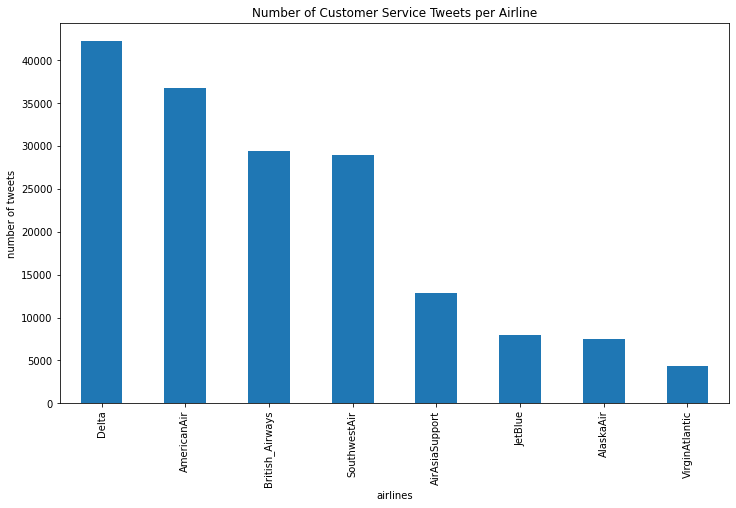

In [38]:
# number of customer service tweets per airline
plt.figure(figsize=(12,7))
airlines_df.author_id.value_counts().plot(kind="bar", 
                                          xlabel="airlines", 
                                          ylabel="number of tweets", 
                                          title="Number of Customer Service Tweets per Airline");

In [39]:
# get customer issue tweets into one dataframe
issues_df = pd.DataFrame(columns=twcs_df.columns)
for airline,dataframes in tweets_dict.items():
    issues_df = issues_df.append(dataframes["pre"])
issues_df.set_index("tweet_id", inplace=True)

In [40]:
# get airline response times
response_times = {airline:[] for airline in airlines}
for tweet in airlines_df.itertuples():
    if pd.notna(tweet.in_response_to_tweet_id):
        idx = int(tweet.in_response_to_tweet_id)
        if idx in issues_df.index:
            response_times[tweet.author_id].append((tweet.created_at - issues_df.loc[idx].created_at).total_seconds())

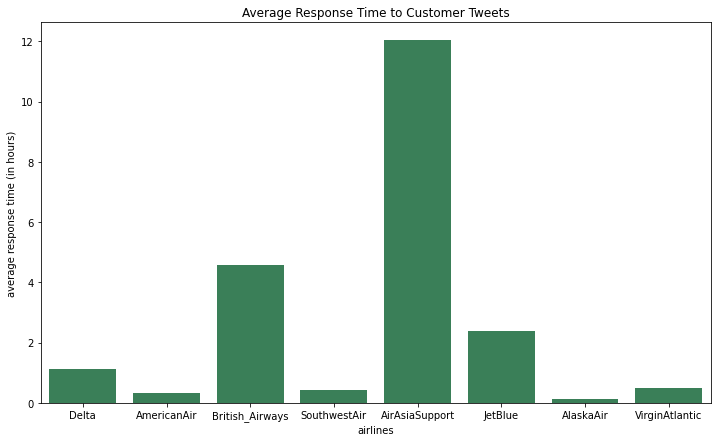

In [41]:
x, y = [], []
for airline,times in response_times.items():
    x.append(airline)
    y.append(np.mean(times)/3600.0)
plt.figure(figsize=(12,7))
plt.xlabel("airlines")
plt.ylabel("average response time (in hours)")
plt.title("Average Response Time to Customer Tweets")
sns.barplot(x=x, y=y, color="seagreen");

* Most airlines respond to their customer's tweets in less than two hours, but British Airways, Air Asia, and JetBlue take much longer, with the slowest to respond, Air Asia, taking on average 12 hours to reply to customer tweets. It will be interesting to see if there is any correlation between response time and the customers' satisfaction based on sentiment analysis. 

In [42]:
# find the average length of airline tweets
pd.set_option('mode.chained_assignment',None)
def find_tweet_length(tweet):
    return len(tweet.split())
airlines_df["tweet_length"] = airlines_df["text"].map(find_tweet_length)

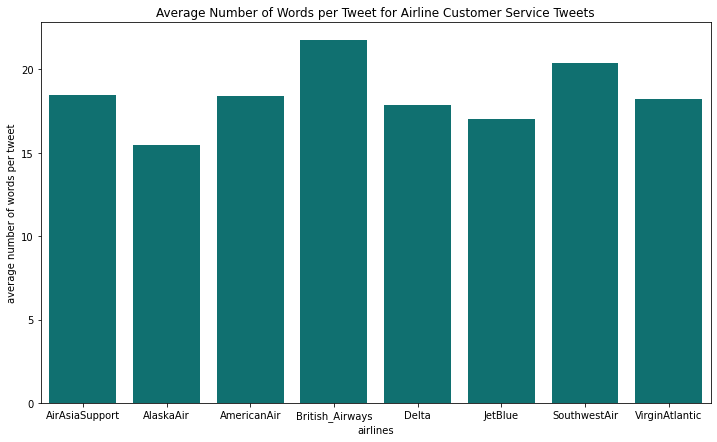

In [48]:
avg_tweet_length = airlines_df.groupby(by="author_id").agg({"tweet_length":"mean"})
plt.figure(figsize=(12,7))
sns.barplot(x=avg_tweet_length.index, y=avg_tweet_length.tweet_length, color="teal")
plt.xlabel("airlines")
plt.ylabel("average number of words per tweet")
plt.title("Average Number of Words per Tweet for Airline Customer Service Tweets")
plt.show();

* The airlines all average 15 to 20 words per tweet. Therefore, the number of words per tweet is not likely to help distinguish what makes one airline's Twitter customer service different than another's. 

#### Word Clouds <a id="Word_Clouds"></a>

In [44]:
# transform the airline customer service tweets
tweet_list = transform_corpus(airlines_df["text"].to_list())

# get the transformed tweets as a list of words
lt = []
for t in tweet_list:
    lt.extend(t)

# join the list of words into one string
tweet_string = " ".join(lt)

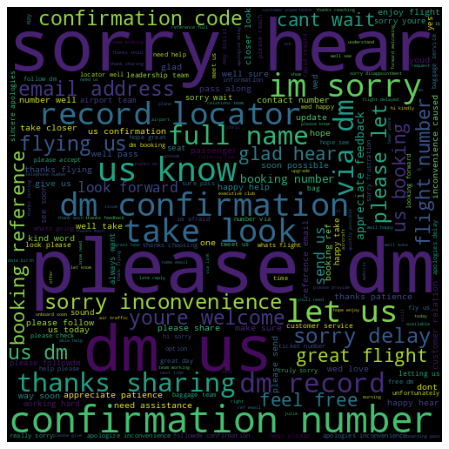

In [45]:
# word cloud of the customer service tweets for all the airlines
word_cloud = WordCloud(width=500, height=500, random_state=42).generate(tweet_string)
plt.figure(figsize=(8,8))
plt.imshow(word_cloud)
plt.axis("off");

In [46]:
# word cloud of customer tweets inbound to airlines 
# get tweets into a list
pre_tweets = []
for airline,dataframes in tweets_dict.items():
    pre_tweets.extend(dataframes["pre"]["transformed_text"])

# make list into a string
lt = []
for t in pre_tweets:
    lt.extend(t)
pre_string = " ".join(lt)

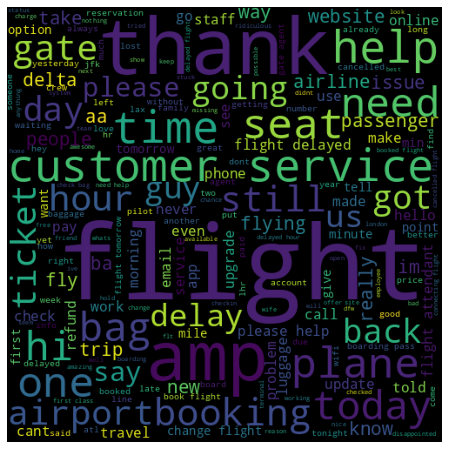

In [47]:
# make word cloud
word_cloud = WordCloud(width=500, height=500, random_state=42).generate(pre_string)
plt.figure(figsize=(8,8))
plt.imshow(word_cloud)
plt.axis("off");